In [1]:
import pandas as pd
from scipy.stats import pearsonr

from modules.plotting_scripts import plot_surprisals, get_avg_df, plot_avg_pos_neg

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict

def trend_categories(df, first_step=True):

    def determine_trend(values):
        X = np.arange(len(values)).reshape(-1, 1)
        model = LinearRegression().fit(X, values)
        slope = model.coef_[0]
        return 'Increasing' if slope > 0 else 'Decreasing'

    categories = defaultdict(lambda: [0, []])

    if not first_step:
        df = df[df['Steps'] != 0]
        
    grouped = df.groupby('Token')
    
    for word, word_data in grouped:
        surprisal_values = word_data['MeanSurprisal'].values.reshape(-1, 1)
        antisurprisal_values = word_data['MeanNegSurprisal'].values.reshape(-1, 1)
        
        surprisal_trend = determine_trend(surprisal_values)
        antisurprisal_trend = determine_trend(antisurprisal_values)
        
        key = f"{surprisal_trend}-{antisurprisal_trend}"
        categories[key][0] += 1
        categories[key][1].append(word)
    
    return categories

In [3]:
path = '../results/lexique_results/indiv_surprisals_full.tsv'
indiv_surprisals = pd.read_csv(path, delimiter='\t')

indiv_surprisals = indiv_surprisals.assign(
    MeanSurprisal=indiv_surprisals.groupby(['Steps', 'Token'])['Surprisal'].transform('mean'),
    MeanNegSurprisal=indiv_surprisals.groupby(['Steps', 'Token'])['NegSurprisal'].transform('mean')
)

indiv_surprisals

,Steps,Token,Context,Surprisal,NegSurprisal,MeanSurprisal,MeanNegSurprisal
0,0,a,"[101, 2728, 8945, 11314, 2121, 2003, 2019, 239...",14.215013,14.323027,14.225594,14.234500
1,0,a,"[101, 2023, 2001, 2628, 2011, 103, 4626, 2535,...",13.940619,14.543520,14.225594,14.234500
2,0,a,"[101, 1999, 2432, 8945, 11314, 2121, 5565, 103...",14.588675,14.688922,14.225594,14.234500
3,0,a,"[101, 2002, 2001, 2856, 2011, 2198, 14381, 199...",13.849343,14.169744,14.225594,14.234500
4,0,a,"[101, 2002, 2596, 2006, 1037, 2294, 2792, 1997...",13.696613,13.988950,14.225594,14.234500
...,...,...,...,...,...,...,...
3064889,2000000,zoom,"[101, 2002, 2915, 1996, 2878, 2143, 2012, 1996...",1.668615,7.264644,2.738938,13.967112
3064890,2000000,zu,"[101, 1996, 2047, 2142, 2163, 3212, 103, 2213,...",0.002864,29.544127,2.828315,27.215050
3064891,2000000,zu,"[101, 4415, 11383, 4874, 22486, 1005, 1055, 64...",0.000113,28.785532,2.828315,27.215050
3064892,2000000,zu,"[101, 2002, 2036, 2354, 1010, 2030, 2018, 2081...",6.268449,24.433737,2.828315,27.215050


In [4]:
example_counts = indiv_surprisals[indiv_surprisals.Steps == 0].Token.value_counts().reset_index().rename(columns={'count': 'Frequency'})
example_counts

,Token,Frequency
0,a,512
1,that,512
2,in,512
3,he,512
4,at,512
...,...,...
9073,demonstration,1
9074,demographic,1
9075,provincial,1
9076,provocative,1


In [5]:
surprisals = indiv_surprisals[['Steps', 'Token', 'MeanSurprisal', 'MeanNegSurprisal']].drop_duplicates().reset_index(drop=True)
surprisals = surprisals.merge(example_counts)
surprisals

,Steps,Token,MeanSurprisal,MeanNegSurprisal,Frequency
0,0,a,14.225594,14.234500,512
1,0,aa,15.597247,15.751283,16
2,0,abandon,15.298998,15.042455,1
3,0,abandoned,14.781739,14.788133,26
4,0,abandoning,14.522403,14.334804,1
...,...,...,...,...,...
263257,2000000,zone,4.706525,22.451706,20
263258,2000000,zones,2.175875,23.845009,5
263259,2000000,zoo,5.894639,15.055669,2
263260,2000000,zoom,2.738938,13.967112,2


In [56]:
categories = trend_categories(surprisals)
categories_df = pd.DataFrame(categories, index=['count', 'words']).transpose()
categories_df

,count,words
Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando..."
Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations..."
Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci..."
Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ..."


In [57]:
infreq = surprisals[surprisals.Frequency <= 10]
infreq_tokens = infreq.Token.unique()
len(infreq_tokens)

7231

In [58]:
# proportion of the category covered by infrequent tokens
categories_df['cat_coverage'] = categories_df.words.apply(lambda x: round(len((set(x).intersection(infreq_tokens))) / len(x), 2))

# proportion of infrequent tokens in each category
categories_df['infreq_prop'] = categories_df.words.apply(lambda x: round(len((set(x).intersection(infreq_tokens))) / len(infreq_tokens), 2))

categories_df

,count,words,cat_coverage,infreq_prop
Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando...",0.78,0.89
Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations...",1.00,0.07
Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci...",0.99,0.03
Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ...",1.00,0.01


In [59]:
def calculate_stats(word_list, word_freqs_df):
    frequencies = word_freqs_df[word_freqs_df['Token'].isin(word_list)]['Frequency']
    return pd.Series([int(frequencies.min()), int(frequencies.max()), int(frequencies.median()), round(frequencies.mean())],
                     index=['min_freq', 'max_freq', 'median_freq', 'rounded_mean_freq'])

categories_df[['min_freq', 'max_freq', 'median_freq', 'rounded_mean_freq']] = categories_df['words'].apply(
    lambda words: calculate_stats(words, surprisals)
)

categories_df = categories_df.reset_index().rename(columns={'index': 'trend_category'})
categories_df


,trend_category,count,words,cat_coverage,infreq_prop,min_freq,max_freq,median_freq,rounded_mean_freq
0,Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando...",0.78,0.89,1,512,4,13
1,Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations...",1.00,0.07,1,10,1,2
2,Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci...",0.99,0.03,1,18,1,2
3,Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ...",1.00,0.01,1,2,1,1


In [60]:
categories_df.to_csv('../results/surp_antisurp_trends.csv', index=None)
df = pd.read_csv('../results/surp_antisurp_trends.csv')
df

,trend_category,count,words,cat_coverage,infreq_prop,min_freq,max_freq,median_freq,rounded_mean_freq
0,Decreasing-Increasing,8309,"['a', 'aa', 'abandon', 'abandoned', 'abandonin...",0.78,0.89,1,512,4,13
1,Decreasing-Decreasing,487,"['abducted', 'abstract', 'academics', 'accommo...",1.00,0.07,1,10,1,2
2,Increasing-Increasing,243,"['absorption', 'accelerating', 'accessibility'...",0.99,0.03,1,18,1,2
3,Increasing-Decreasing,39,"['arresting', 'banging', 'breakers', 'bump', '...",1.00,0.01,1,2,1,1


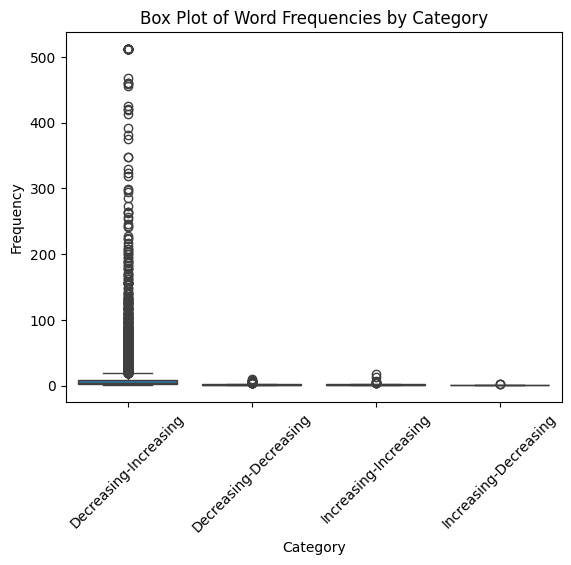

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

expanded_df = categories_df.explode('words')[['trend_category', 'words']].sort_values('words')

merged_df = pd.merge(expanded_df, surprisals[surprisals.Steps == 0], left_on='words', right_on='Token')

sns.boxplot(x='trend_category', y='Frequency', data=merged_df)

plt.title('Box Plot of Word Frequencies by Category')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()


In [48]:
import math
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


def fit_linear(X:np.ndarray, y:np.ndarray, first_step=True) -> Dict[str, float]:
    if not first_step:
        X, y = X[1:], y[1:]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    alpha = model.coef_[0]  # slope
    beta = model.intercept_
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    return X.flatten(), y_pred, {'model': 'Linear Regression', 'alpha': alpha, 'beta': beta, 'R2': r2, 'MSE': mse}

def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def polynomial_model(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def linear_model(x, a, b):
    return a * x + b

def fit_model(model, x, y, initial_guess, bounds=(-np.inf, np.inf)):
    popt, _ = curve_fit(model, x, y, p0=initial_guess, bounds=bounds)
    y_fit = model(x, *popt)
    return popt, y_fit

def select_best_model(x, y):
    models = [
        (exponential_decay, [y.max(), 1e-6, y.min()], 'Exponential Decay'),
        (polynomial_model, [0, 0, 0, y.mean()], 'Polynomial Model'),
        (linear_model, [0, y.mean()], 'Linear Model')
    ]
    
    best_model = None
    best_fit = None
    best_score = np.inf
    best_name = ""
    best_rate = None
    
    for model, initial_guess, name in models:
        try:
            popt, y_fit = fit_model(model, x, y, initial_guess)
            print(name, popt)
            mse = mean_squared_error(y, y_fit)
            if mse < best_score:
                r2 = r2_score(y, y_fit)
                best_score = mse
                best_model = model
                best_fit = y_fit
                best_name = name
                
                # Extract convergence rate
                if name == 'Exponential Decay':
                    best_rate = popt[1]  # b parameter for convergence rate
                elif name == 'Polynomial Model':
                    # Optionally use polynomial coefficients to estimate rate
                    best_rate = popt[:3]  # Could analyze the coefficients
                elif name == 'Linear Model':
                    best_rate = popt[0]  # Slope (a) as rate of change
        except RuntimeError as e:
            continue
    
    return best_model, best_fit, best_name, best_score, r2, best_rate

def plot_surprisals(words:List[str], surprisals_df, show_error_interval=False, neg_samples=False, first_step=True, fit_line=False, fit_curve=False, convergence=False, return_outputs=False):
    """ 
    If first_step is set to False, neither the correlations nor the linear model will consider 
    the first step, but the first step will still be shown on the plot.
    """
    num_words = len(words)
    cols = min(num_words, 3)
    rows = math.ceil(num_words / cols)

    plt.style.use('ggplot')
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = np.atleast_2d(axs)

    correlations = {}
    all_metrics = {}

    for i, word in enumerate(words):   
        word_data = surprisals_df[surprisals_df['Token'] == word].reset_index(drop=True)
        if word_data.empty:
            print(f'No data found for the word "{word}"')
            continue

        ax = axs[i//cols, i%cols]

        metrics = {}
        
        x = word_data['Steps'].values
        y_pos = word_data['MeanSurprisal'].values
        
        # Plot positive surprisals
        if show_error_interval:
            try:
                sns.lineplot(data=word_data, x='Steps', y='Surprisal', marker='o', color='darkseagreen', 
                             errorbar=('ci', 100), label='Positive Samples' if i == num_words - 1 else None, 
                             ax=ax, legend=(i == num_words - 1))
            except Exception as e:
                print(e)
                ax.plot(x, y_pos, marker='o', color='darkseagreen', label='Positive Samples')
        else:
            ax.plot(x, y_pos, marker='o', color='darkseagreen', label='Positive Samples')

        if convergence:
            lowest_surprisal = min(y_pos)
            lowest_step = x[np.argmin(y_pos)]
            ax.axhline(lowest_surprisal, color='#043927', linestyle=':')
            ax.axvline(lowest_step, color='#043927', linestyle=':')

        if fit_line:
            # Fit linear model for positive samples
            X_flat, y_pred_pos, metrics['positive'] = fit_linear(x.reshape(-1, 1), y_pos, first_step=first_step)
            ax.plot(X_flat, y_pred_pos, linestyle='--', color='#043927', label='Fitted Line (+)')
            alpha = metrics['positive']['alpha']
            ax.text(x[-1], y_pred_pos[-1] + 1 if alpha > 0 else y_pred_pos[-1] + 3, 
                    f"α⁺ = {alpha:.2e}", color='#043927', fontsize=8, ha='right')

        if fit_curve:
            # Fit and plot the best curve for positive samples
            best_model, best_fit, best_name, best_score, r2, best_rate = select_best_model(x, y_pos)
            if best_model is not None:
                ax.plot(x, best_fit, label=f'Positive Best Fit', color='#043927')
                metrics['positive'] = {'model': best_name, 'R2': r2, 'MSE': best_score, 'Convergence_rate': best_rate}
            else:
                print(f"Could not fit any model for the positive samples of word '{word}'")

        if neg_samples:
            y_neg = word_data['MeanNegSurprisal'].values
            
            # Plot negative surprisals
            if show_error_interval:
                try:
                    sns.lineplot(data=word_data, x='Steps', y='NegSurprisal', marker='o', color='indianred', 
                                 errorbar=('ci', 100), label='Negative Samples'if i == num_words - 1 else None, 
                                 ax=ax, legend=(i == num_words - 1))   
                except Exception as e:
                    print(e)         
                    ax.plot(word_data['Steps'], word_data['MeanNegSurprisal'], marker='o', color='indianred', label='Negative Samples')
            else:
                ax.plot(word_data['Steps'], word_data['MeanNegSurprisal'], marker='o', color='indianred', label='Negative Samples')
            
            if convergence:
                highest_antisurprisal = max(y_neg)
                highest_step = x[np.argmax(y_neg)]
                ax.axhline(highest_antisurprisal, color='#8D021F', linestyle=':')
                ax.axvline(highest_step, color='#8D021F', linestyle=':')
            
            if fit_line:
                # Fit linear model for negative samples
                X_flat, y_pred_neg, metrics['negative'] = fit_linear(x.reshape(-1, 1), y_neg, first_step=first_step)
                ax.plot(X_flat, y_pred_neg, linestyle='--', color='#8D021F', label='Fitted Line (-)')
                alpha = metrics['negative']['alpha']
                ax.text(x[-1], y_pred_neg[-1] - 2 if alpha < 0 else y_pred_neg[-1] - 4, 
                        f"α⁻ = {alpha:.2e}", color='#8D021F', fontsize=8, ha='right')
            
            if fit_curve:
                # Fit and plot the best curve for positive samples
                best_model, best_fit, best_name, best_score, r2, best_rate = select_best_model(x, y_neg)
                if best_model is not None:
                    ax.plot(x, best_fit, label=f'Negative Best Fit', color='#8D021F')
                    metrics['negative'] = {'model': best_name, 'R2': r2, 'MSE': best_score, 'Convergence_rate': best_rate}
                else:
                    print(f"Could not fit any model for the negative samples of word '{word}'")

            # Calculate correlation
            if not first_step:
                word_data = word_data[word_data['Steps'] != 0]                
            corr, _ = pearsonr(word_data['MeanSurprisal'], word_data['MeanNegSurprisal'])
            correlations[word] = corr
            ax.set_title(f'"{word}"', pad=18)
            ax.text(0.5, 1.02, f'Pos-Neg Correlation: {corr:.2f}', fontsize=10, ha='center', transform=ax.transAxes)

        else:
            ax.set_title(f'"{word}"')
        
        ax.set_xlabel('Steps')
        ax.set_ylabel('Mean surprisal')

        all_metrics[word] = metrics
    
    # Remove empty subplots
    for j in range(i+1, rows*cols):
        fig.delaxes(axs.flatten()[j])
    
    plt.tight_layout()

    # Legend
    last_ax = axs.flatten()[i]
    handles, labels = last_ax.get_legend_handles_labels()
    last_ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, (i % cols) / cols + 0.5 / cols), title="Legend")   
    
    plt.show()

    if return_outputs:
        return correlations, all_metrics


Exponential Decay [6.25890501e+00 9.88721999e-06 8.15261080e+00]
Polynomial Model [-3.92665819e-18  1.37473077e-11 -1.43561885e-05  1.23473604e+01]
Linear Model [-1.85325533e-06  1.06297120e+01]
Exponential Decay [-1.06746759e+01  9.18019393e-05  2.64434937e+01]
Polynomial Model [ 1.92419057e-18 -6.11966386e-12  6.88515205e-06  2.39810396e+01]
Linear Model [1.87445909e-06 2.45965003e+01]
Exponential Decay [-8.72501965e-01  6.77251078e-07  1.15991262e+01]
Polynomial Model [-7.97878568e-19  2.04828377e-12 -8.62599275e-07  1.08531391e+01]
Linear Model [3.29968877e-07 1.07773532e+01]
Exponential Decay [1.63889321e+01 1.29776547e-07 4.72889971e+00]
Polynomial Model [ 2.29573947e-18 -6.48648772e-12  2.60949801e-06  2.06361576e+01]
Linear Model [-1.89459301e-06  2.10716540e+01]


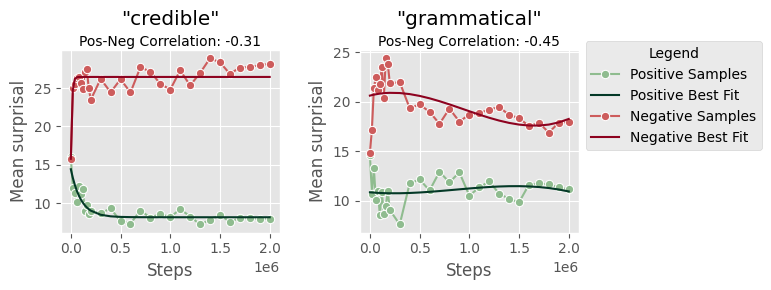

({'credible': -0.31070728458876706, 'grammatical': -0.44590446512515436},
 {'credible': {'positive': {'model': 'Exponential Decay',
    'R2': 0.8118374748224015,
    'MSE': 0.6747443487605245,
    'Convergence_rate': 9.887219990750021e-06},
   'negative': {'model': 'Exponential Decay',
    'R2': 0.689340910357445,
    'MSE': 1.7305366753924778,
    'Convergence_rate': 9.180193934419027e-05}},
  'grammatical': {'positive': {'model': 'Polynomial Model',
    'R2': 0.03244929110564354,
    'MSE': 2.094740139893447,
    'Convergence_rate': array([-7.97878568e-19,  2.04828377e-12, -8.62599275e-07])},
   'negative': {'model': 'Polynomial Model',
    'R2': 0.3325549791802249,
    'MSE': 3.360611959833377,
    'Convergence_rate': array([ 2.29573947e-18, -6.48648772e-12,  2.60949801e-06])}}})

In [49]:
words = ['credible', 'grammatical']
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_curve=True, first_step=False, return_outputs=True)